In [1]:
from coosys import cartesian_to_kepler as ctk, cartesian_to_quaternion as ctq
from coosys import kepler_to_cartesian as ktc, quaternion_to_cartesian as qtc
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression as LR
from sklearn.preprocessing import PolynomialFeatures as PF
from sklearn.model_selection import train_test_split as tts
from scipy.interpolate import UnivariateSpline as US
from scipy import signal
import spectrum
from tqdm.auto import tqdm
tqdm.pandas()

from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import models as M
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K

D:\Anaconda3\envs\Standard\lib\site-packages\tqdm\std.py:654: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
base = 1.3885 * 10**9

train_data = pd.read_csv("IDAO 2020/train.csv", encoding="utf8")
train_data["epoch"] = pd.to_datetime(train_data["epoch"]).apply(pd.Timestamp.timestamp) - base

test_data = pd.read_csv("IDAO 2020/Track 1/test.csv", encoding="utf8")
test_data["epoch"] = pd.to_datetime(test_data["epoch"]).apply(pd.Timestamp.timestamp) - base

In [3]:
gamma_km = 398603

def transform_row(row, func):
    return func(row.values)

def transform_dataset(data, func=lambda data: ctk(data, gamma_km), 
                      columns_from=("x", "y", "z", "Vx", "Vy", "Vz"), 
                      columns_to=("a", "e", "inclination", "longitude", "argument", "anomaly")):
    new_data = data.loc[:, list(columns_from)].progress_apply(transform_row, axis=1, result_type="expand", args=(func, ))
    new_data.columns = columns_to
    return data.drop(list(columns_from), axis=1).join(new_data)

Для осмысленного применения методов анализа временных рядов требуется привести ряд к одинаковым временным интервалам. Поскольку рассматривается сверточно-разверточная сеть, то требуется также привести ряд к определенному числу точек. Поэтому разобьем обучающую выборку на определенное число точек с одинаковыми интервалами.

In [4]:
def mask_spline(x, y, x_spline):
    mask = np.logical_not(np.isnan(y))
    border = x[mask][-1]
    spline = US(x[mask], y[mask], k=1, s=0)(x_spline[x_spline <= border])
    other_part = np.ones(x_spline[x_spline > border].size)
    other_part[:] = float('nan')
    return np.concatenate([spline, other_part])

def sat_normalize(data, coordinates, x_spline):
    x = data["epoch"].to_numpy()    
    y_splines = [mask_spline(x, data[coordinate].to_numpy(), x_spline)  for coordinate in coordinates]
    
    result = pd.DataFrame(columns = ["epoch"] + coordinates)
    result["epoch"] = x_spline
    for coordinate, y_spline in zip(coordinates, y_splines):
        result[coordinate] = y_spline
    
    return result

def normalize(data, coordinates, x_spline):
    result = pd.DataFrame(columns = ["sat_id", "epoch"] + coordinates)
    
    sat_results = []
    
    for sat_id in tqdm(data["sat_id"].unique()):
        sat_result = sat_normalize(data[data.sat_id == sat_id], coordinates, x_spline)
        sat_result["sat_id"] = sat_id
        sat_results.append(sat_result)

    return pd.concat(sat_results)

def denormalize(data, coordinates, xs):
    result = pd.DataFrame(columns = ["id", "epoch", "sat_id"] + coordinates)
    
    sat_results = []
    
    for sat_id in tqdm(data["sat_id"].unique()):
        sat_result = sat_normalize(data[data.sat_id == sat_id], coordinates, xs[sat_id][1])
        sat_result["sat_id"] = sat_id
        sat_result["id"] = xs[sat_id][0]
        sat_results.append(sat_result)

    return pd.concat(sat_results)

In [5]:
factor = 15
N = 2**factor

x_spline = np.linspace(train_data.groupby("sat_id")["epoch"].min().max(), train_data.groupby("sat_id")["epoch"].max().min(), N)

normalized_train_data = normalize(train_data, ["x", "y", "z", "Vx", "Vy", "Vz", 
                                               "x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"], 
                                  x_spline)

In [6]:
coordinates_true = ["x", "y", "z", "Vx", "Vy", "Vz"]
coordinates_sim = ["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]

def batch_generator(data, sats, batch_size=32, shuffle=True, cycling=True):
    X = []
    y = []
    passed = False
    while cycling or not passed:
        if shuffle:
            np.random.shuffle(sats)
        for sat in sats:
            X.append(data[data.sat_id == sat][coordinates_sim].to_numpy())
            y.append(data[data.sat_id == sat][coordinates_true].to_numpy())
            if len(X) == batch_size:
                yield np.array(X, dtype="float32"), np.array(y, dtype="float32")
                X = []
                y = []
        passed = True
    
    if len(X) > 0:
        yield np.array(X), np.array(y)
    

Посчитаем smape для приближения динамической модели.

In [7]:
def smape(y_true, y_pred):
    return 100 * (1 - K.mean(K.abs(y_true - y_pred) / (K.abs(y_true) + K.abs(y_pred))))

smape_sum = 0.
iters = 20

for X, y in tqdm(batch_generator(normalized_train_data, normalized_train_data.sat_id.unique(), normalized_train_data.sat_id.unique().size // iters, cycling=False), total=iters):
    smape_sum += smape(y, X)
    
smape_base = smape_sum / iters
smape_base

<tf.Tensor: id=302, shape=(), dtype=float32, numpy=84.97182>

Построим сверточно-разверточную нейросеть, рассматривая решение как coordinates = coordinates_sim + output.

In [8]:
def Conv1DTranspose(filters, kernel_size, strides=1, padding='same', activation="linear"):
    return lambda x: L.Lambda(lambda y: K.squeeze(y, axis=2))(
        L.Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding, activation=activation)(
            L.Lambda(lambda z: K.expand_dims(z, axis=2))(x)
        )
    )

def add_conv_block(base, neurons=8, kernel_shape=3, pool_shape=2, dropout=0.1, alpha=0.1):
    return L.BatchNormalization()(
             L.AveragePooling1D(pool_shape)(
               L.Conv1D(neurons, kernel_shape, padding="same", activation=L.LeakyReLU(alpha))(  
                 L.Dropout(dropout)(
                   L.Conv1D(neurons, kernel_shape, padding="same", activation=L.LeakyReLU(alpha))(base)
                 )
               )
             )
           )

def add_deconv_block(base, neurons=8, kernel_shape=3, pool_shape=2, dropout=0.1, alpha=0.1):
    return L.BatchNormalization()(
             Conv1DTranspose(neurons, kernel_shape, padding="same", activation=L.LeakyReLU(alpha))(  
               L.Dropout(dropout)(
                 Conv1DTranspose(neurons, kernel_shape, padding="same", strides=2, activation=L.LeakyReLU(alpha))(
                   base
                 )
               )
             )      
           )


def energy_loss(y_true, y_pred):
    sq_true = y_true**2
    r = K.sum(sq_true[:, :, :3], axis=2)**0.5
    v = K.sum(sq_true[:, :, 3:], axis=2)**0.5
    
    sq_diff = (y_true - y_pred)**2
    r_diff = K.sum(sq_diff[:, :, :3], axis=2)**0.5
    v_diff = K.sum(sq_diff[:, :, 3:], axis=2)**0.5
    
    r_rel = r_diff / r
    v_rel = v_diff / v
    
    S = K.mean((r_rel + v_rel) / 2)

    return S


def build_model(input_factor=15, depth=15):
    input_layer = L.Input(shape=(2**input_factor, 6))
    
    batch_norm = L.BatchNormalization()(input_layer)
    
    conv_block = batch_norm
    
    for i in range(depth):
        conv_block = add_conv_block(conv_block, 6 * 2**(i // 3))
    
    deconv_block = conv_block
    
    for i in range(depth - 1, -1, -1):
        deconv_block = add_deconv_block(deconv_block, 6 * 2**(i // 3))
        
    predictions = Conv1DTranspose(6, 3, padding="same")(deconv_block)
    result = L.Add()([input_layer, predictions])

    model = M.Model(inputs=input_layer, outputs=result)
    model.summary()
    model.compile(optimizer='adam', loss=energy_loss, metrics=[smape])
    return model

In [9]:
model = build_model(factor)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32768, 6)]   0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32768, 6)     24          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 32768, 6)     114         batch_normalization[0][0]        
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32768, 6)     0           conv1d_1[0][0]                   
______________________________________________________________________________________________

Разделим спутники на обучающую и тестовую выборку, обучим сеть на первой и посчитает smape на второй.

In [10]:
train_sats, test_sats = tts(normalized_train_data.sat_id.unique().astype("int32"), test_size=0.2, random_state=146)
batch_size = 16

In [11]:
model.fit_generator(batch_generator(normalized_train_data, train_sats, batch_size), 
                    steps_per_epoch=train_sats.size // batch_size, epochs=10, 
                    validation_data=batch_generator(normalized_train_data, test_sats, batch_size), 
                    validation_steps=test_sats.size // batch_size)

Epoch 1/10
30/30 [==============================] - 42s 1s/step - loss: 0.2872 - smape: 81.3178 - val_loss: 0.1976 - val_smape: 84.5831
Epoch 2/10
30/30 [==============================] - 33s 1s/step - loss: 0.2134 - smape: 84.6438 - val_loss: 0.1891 - val_smape: 85.1517
Epoch 3/10
30/30 [==============================] - 33s 1s/step - loss: 0.2064 - smape: 84.8493 - val_loss: 0.2115 - val_smape: 83.9539
Epoch 4/10
30/30 [==============================] - 35s 1s/step - loss: 0.2056 - smape: 84.8707 - val_loss: 0.1859 - val_smape: 85.1896
Epoch 5/10
30/30 [==============================] - 34s 1s/step - loss: 0.2044 - smape: 84.8940 - val_loss: 0.1880 - val_smape: 85.0622
Epoch 6/10
30/30 [==============================] - 33s 1s/step - loss: 0.2041 - smape: 84.8934 - val_loss: 0.1856 - val_smape: 85.7264
Epoch 7/10
30/30 [==============================] - 33s 1s/step - loss: 0.2037 - smape: 84.9079 - val_loss: 0.1857 - val_smape: 85.3637
Epoch 8/10
30/30 [==============================

Получаем, что в обучающей выборке, и в тестовой, smape примерно соответствует изначальному, из чего делаем вывод, что сеть неэффективна. Нарисуем графики ошибок предсказаний.

In [12]:
X = normalized_train_data[normalized_train_data.sat_id == test_sats[0]][coordinates_sim].to_numpy().reshape(1, N, 6)
y = normalized_train_data[normalized_train_data.sat_id == test_sats[0]][coordinates_true].to_numpy().reshape(1, N, 6)
pred = model.predict(X)

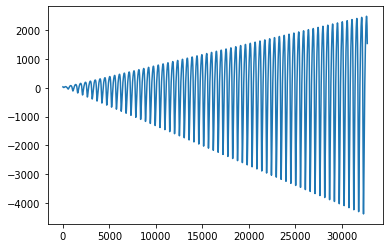

In [13]:
plt.plot(y[0, :, 0] - X[0, :, 0])
plt.show()

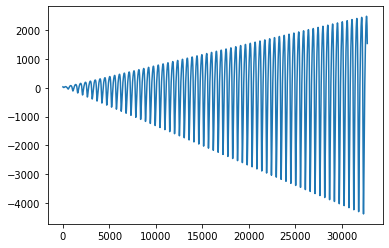

In [14]:
plt.plot(y[0, :, 0] - pred[0, :, 0])
plt.show()

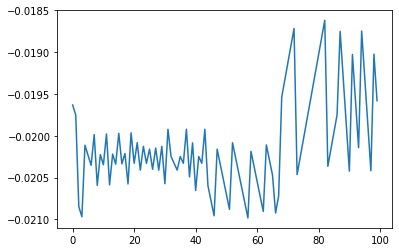

In [15]:
plt.plot((pred[0, :, 0] - X[0, :, 0])[:100])
plt.show()

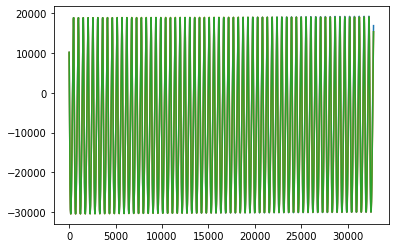

In [16]:
plt.plot(y[0, :, 0])
plt.plot(pred[0, :, 0])
plt.plot(X[0, :, 0])
plt.show()

Получаем, что нейросеть сходится практически к нулю. Отсюда получаем, что такой подход к корректировке предсказаний траекторий совершенно неэффективен.